In [1]:
import os
import scanpy as sc
import numpy as np
import anndata as ad
import snapseed as snap

from scarches.models.scpoli import scPoli

 captum (see https://github.com/pytorch/captum).
INFO:lightning_fabric.utilities.seed:Global seed set to 0
/links/groups/treutlein/USERS/zhisong_he/anaconda3/envs/env_scarches/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir("/links/groups/treutlein/USERS/zhisong_he/Work/brain_organoid_atlas/")

# load aggrecell data and generate HVG reduced object

In [4]:
adata = sc.read("data/phase3_final_0516/phase3_aggrecells.h5ad")

In [5]:
adata.var_names_make_unique()

In [6]:
adata.uns['log1p']['base'] = None
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, flavor='seurat', batch_key = 'bio_sample')

In [7]:
adata_hvg = adata[:,adata.var.highly_variable]

In [8]:
adata_hvg.shape

(515802, 2000)

In [10]:
adata_hvg.obs.keys()

Index(['assay_sc', 'assay_differentiation', 'assay_type_differentiation',
       'bio_sample', 'cell_line', 'cell_type', 'development_stage', 'disease',
       'ethnicity', 'gm', 'id', 'individual', 'organ', 'organism', 'sex',
       'state_exact', 'sample_source', 'source_doi',
       'suspension_type_original', 'tech_sample', 'treatment',
       'assay_sc_original', 'cell_line_original', 'cell_type_original',
       'development_stage_original', 'disease_original', 'ethnicity_original',
       'organ_original', 'organism_original', 'sex_original',
       'suspension_type', 'obs_names_original', 'organoid_age_days',
       'publication', 'doi', 'batch', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'leiden_pca_unintegrated_1', 'leiden_pca_unintegrated_80',
       'leiden_pca_rss_1', 'leiden_pca_rss_80',
       'snapseed_pca_unintegrated_level_1',
       'snapseed_p

In [11]:
adata_hvg.obs.snapseed_pca_unintegrated_level_1.value_counts()

neural_progenitor_cell       223615
neuron                       219697
choroid_plexus_epithelium     60261
mesenchymal_cell               7275
astrocyte                      3226
vascular_endothelial_cell       861
oligodendrocyte_lineage         848
microglia                        19
Name: snapseed_pca_unintegrated_level_1, dtype: int64

# build scPoli model given unintegrated level-1 snapseed labels

In [32]:
scpoli_model = scPoli(
    adata=adata_hvg,
    unknown_ct_names=["unknown"],
    condition_key="batch",
    cell_type_keys=["snapseed_pca_unintegrated_level_1"],
    embedding_dim=5,
    hidden_layer_sizes=[512]
)

Embedding dictionary:
 	Num conditions: 396
 	Embedding dim: 5
Encoder Architecture:
	Input Layer in, out and cond: 2000 512 5
	Mean/Var Layer in/out: 512 10
Decoder Architecture:
	First Layer in, out and cond:  10 512 5
	Output Layer in/out:  512 2000 



In [33]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_prototype_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [34]:
scpoli_model.train(
    n_epochs=10,
    pretraining_epochs=8,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=10,
    alpha_epoch_anneal=100
)

 |████████████████----| 80.0%  - val_loss: 963.0210312306 - val_cvae_loss: 963.0210312306
Initializing unlabeled prototypes with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 84 clusters.
 |████████████████████| 100.0%  - val_loss: 981.1017142549 - val_cvae_loss: 970.5917284187 - val_prototype_loss: 10.5099858161 - val_unlabeled_loss: 0.0000000000 - val_labeled_loss: 1.0509985827


In [35]:
import pickle
with open('data/phase3_final_0516/model_scpoli_level1_aggrecells.pickle', 'wb') as file:
    pickle.dump(scpoli_model, file)

In [36]:
data_latent = scpoli_model.get_latent(
    adata_hvg.X, 
    adata_hvg.obs["batch"].values,
    mean=True
)
adata.obsm['X_scpoli_level1'] = data_latent

In [37]:
sc.pp.neighbors(adata, use_rep = "X_scpoli_level1", n_neighbors=20)

In [38]:
sc.tl.umap(adata)

/links/groups/treutlein/USERS/zhisong_he/anaconda3/envs/env_scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/links/groups/treutlein/USERS/zhisong_he/anaconda3/envs/env_scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/links/groups/treutlein/USERS/zhisong_he/anaconda3/envs/env_scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/links/groups/treutlein/USERS/zhisong_he/anaconda3/envs/env_scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


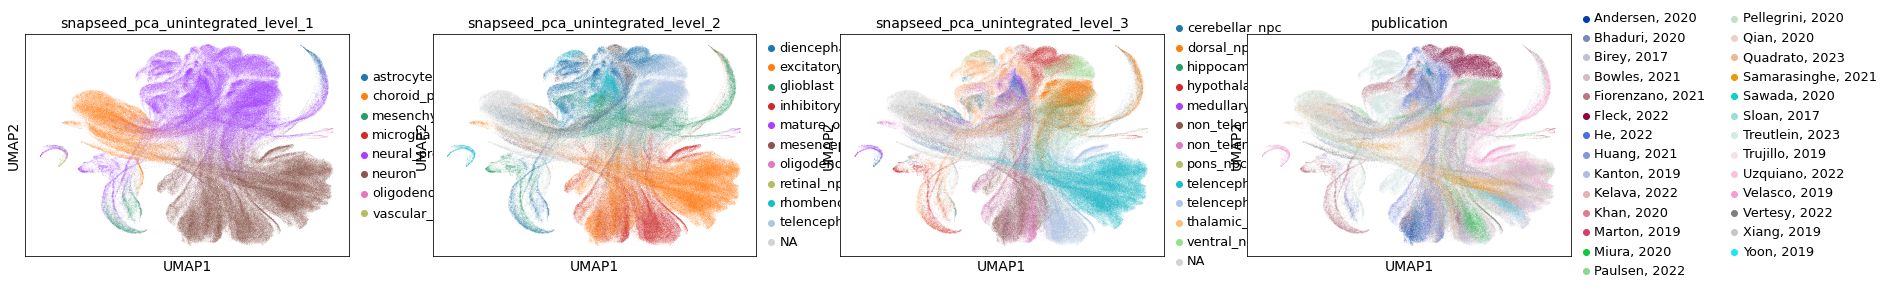

In [39]:
sc.pl.umap(adata, color=['snapseed_pca_unintegrated_level_1', 'snapseed_pca_unintegrated_level_2', 'snapseed_pca_unintegrated_level_3', 'publication'])

In [40]:
adata.write_h5ad("data/phase3_final_0516/phase3_aggrecells.h5ad")

In [46]:
adata.obsm['X_umap_scpoli_level1'] = adata.obsm['X_umap'].copy()

# build scPoli model given unintegrated level-123 snapseed labels

In [41]:
scpoli_model_123 = scPoli(
    adata=adata_hvg,
    unknown_ct_names=["unknown"],
    condition_key="batch",
    cell_type_keys=["snapseed_pca_unintegrated_level_1","snapseed_pca_rss_level_12","snapseed_pca_rss_level_123"],
    embedding_dim=5,
    hidden_layer_sizes=[512]
)

Embedding dictionary:
 	Num conditions: 396
 	Embedding dim: 5
Encoder Architecture:
	Input Layer in, out and cond: 2000 512 5
	Mean/Var Layer in/out: 512 10
Decoder Architecture:
	First Layer in, out and cond:  10 512 5
	Output Layer in/out:  512 2000 



In [42]:
scpoli_model_123.train(
    n_epochs=10,
    pretraining_epochs=8,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=10,
    alpha_epoch_anneal=100
)

 |████████████████----| 80.0%  - val_loss: 964.9530971328 - val_cvae_loss: 964.9530971328
Initializing unlabeled prototypes with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 86 clusters.
 |████████████████████| 100.0%  - val_loss: 1040.5214175847 - val_cvae_loss: 977.3036309708 - val_prototype_loss: 63.2177877970 - val_unlabeled_loss: 0.0000000000 - val_labeled_loss: 6.32177878144


In [43]:
import pickle
with open('data/phase3_final_0516/model_scpoli_level123_aggrecells.pickle', 'wb') as file:
    pickle.dump(scpoli_model_123, file)

In [44]:
data_latent_123 = scpoli_model_123.get_latent(
    adata_hvg.X, 
    adata_hvg.obs["batch"].values,
    mean=True
)
adata.obsm['X_scpoli_level123'] = data_latent_123

In [45]:
sc.pp.neighbors(adata, use_rep = "X_scpoli_level123", n_neighbors=20)

In [47]:
sc.tl.umap(adata)

In [48]:
adata.obsm['X_umap_scpoli_level123'] = adata.obsm['X_umap'].copy()

/links/groups/treutlein/USERS/zhisong_he/anaconda3/envs/env_scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/links/groups/treutlein/USERS/zhisong_he/anaconda3/envs/env_scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/links/groups/treutlein/USERS/zhisong_he/anaconda3/envs/env_scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/links/groups/treutlein/USERS/zhisong_he/anaconda3/envs/env_scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


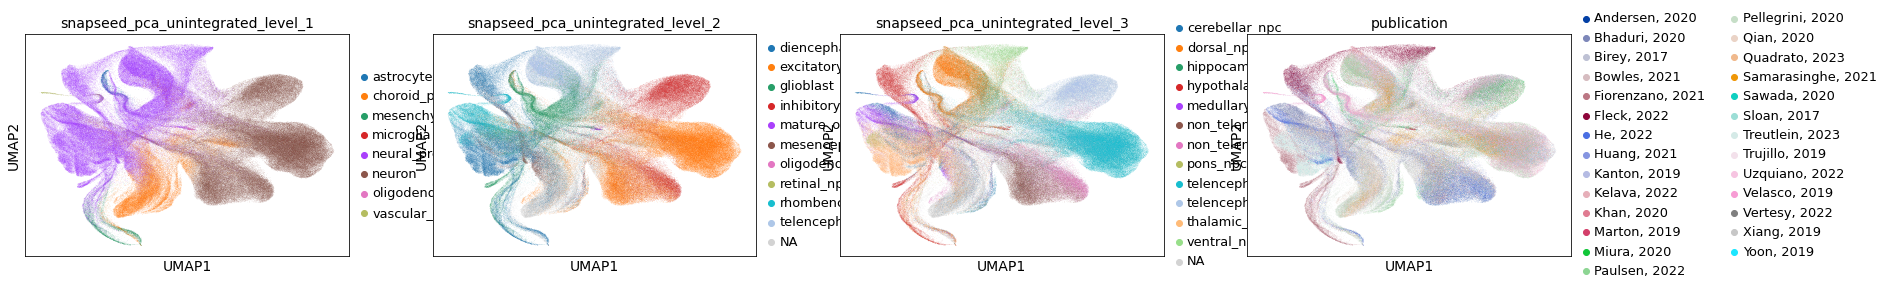

In [49]:
sc.pl.umap(adata, color=['snapseed_pca_unintegrated_level_1', 'snapseed_pca_unintegrated_level_2', 'snapseed_pca_unintegrated_level_3', 'publication'])

In [50]:
adata.write_h5ad("data/phase3_final_0516/phase3_aggrecells.h5ad")

# project single-cell level data to the scPoli latent space

In [53]:
adata_sc = sc.read('data/phase3_final_0516/ZH_processed.h5ad')

In [54]:
adata_sc.var_names_make_unique()

In [55]:
adata_sc_hvg = adata_sc[:,adata.var.highly_variable]

In [56]:
data_latent_sc_1 = scpoli_model.get_latent(
    adata_sc_hvg.X, 
    adata_sc_hvg.obs["batch"].values,
    mean=True
)
adata_sc.obsm['X_scpoli_aggr_level1'] = data_latent_sc_1

In [57]:
data_latent_sc_123 = scpoli_model_123.get_latent(
    adata_sc_hvg.X, 
    adata_sc_hvg.obs["batch"].values,
    mean=True
)
adata_sc.obsm['X_scpoli_aggr_level123'] = data_latent_sc_123

In [58]:
sc.pp.neighbors(adata_sc, use_rep = "X_scpoli_aggr_level1", n_neighbors=20)
sc.tl.umap(adata_sc)
adata_sc.obsm['X_umap_scpoli_aggr_level1'] = adata_sc.obsm['X_umap'].copy()

/links/groups/treutlein/USERS/zhisong_he/anaconda3/envs/env_scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/links/groups/treutlein/USERS/zhisong_he/anaconda3/envs/env_scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/links/groups/treutlein/USERS/zhisong_he/anaconda3/envs/env_scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/links/groups/treutlein/USERS/zhisong_he/anaconda3/envs/env_scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


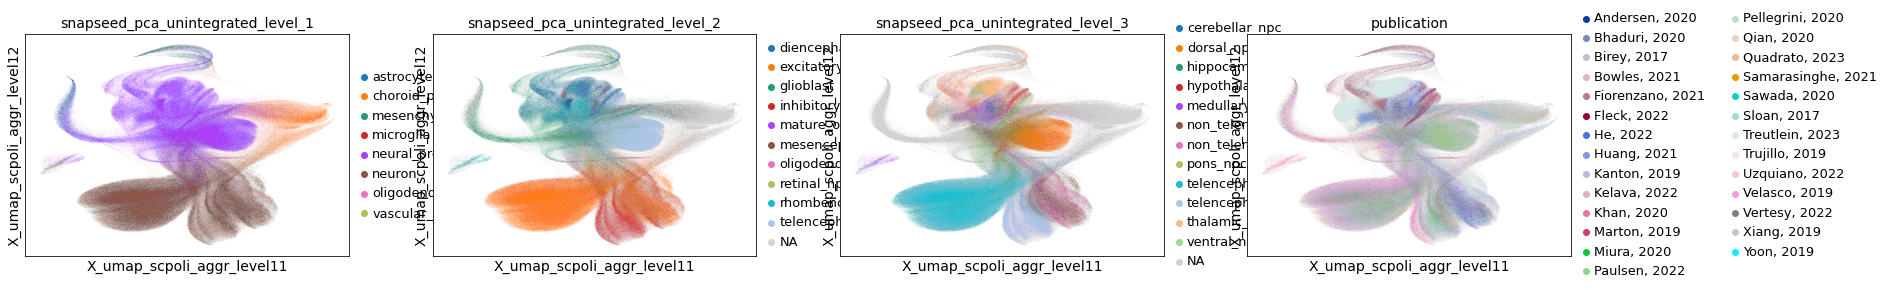

In [61]:
sc.pl.embedding(adata_sc, basis='X_umap_scpoli_aggr_level1', color=['snapseed_pca_unintegrated_level_1', 'snapseed_pca_unintegrated_level_2', 'snapseed_pca_unintegrated_level_3', 'publication'])

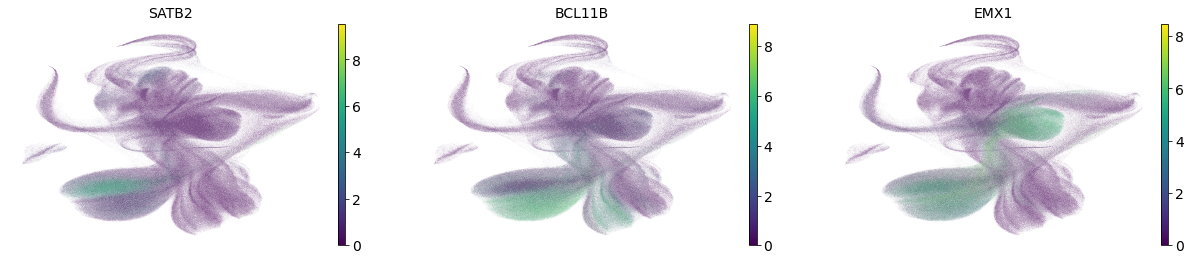

In [66]:
sc.pl.embedding(adata_sc, basis='X_umap_scpoli_aggr_level1', color=['SATB2','BCL11B','EMX1'], frameon = False)

In [ ]:
sc.pp.neighbors(adata_sc, use_rep = "X_scpoli_aggr_level123", n_neighbors=20)
sc.tl.umap(adata_sc)
adata_sc.obsm['X_umap_scpoli_aggr_level123'] = adata_sc.obsm['X_umap'].copy()

/links/groups/treutlein/USERS/zhisong_he/anaconda3/envs/env_scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/links/groups/treutlein/USERS/zhisong_he/anaconda3/envs/env_scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/links/groups/treutlein/USERS/zhisong_he/anaconda3/envs/env_scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/links/groups/treutlein/USERS/zhisong_he/anaconda3/envs/env_scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


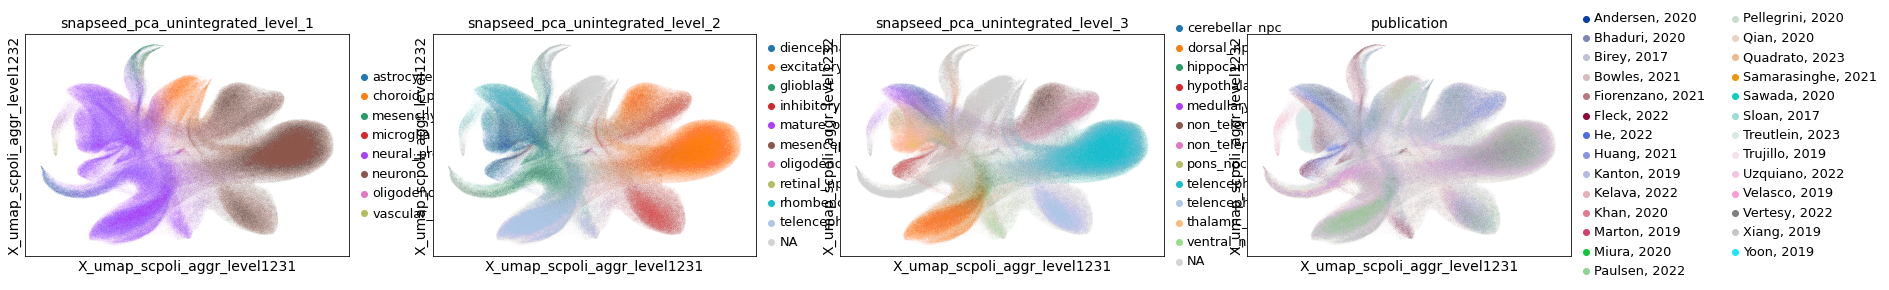

In [62]:
sc.pl.embedding(adata_sc, basis='X_umap_scpoli_aggr_level123', color=['snapseed_pca_unintegrated_level_1', 'snapseed_pca_unintegrated_level_2', 'snapseed_pca_unintegrated_level_3', 'publication'])

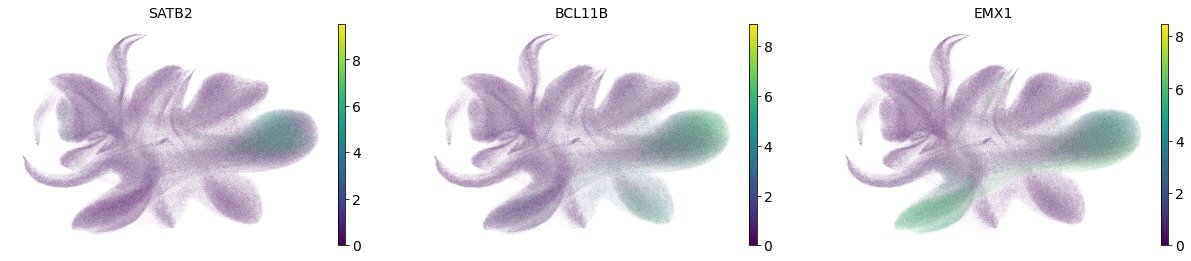

In [65]:
sc.pl.embedding(adata_sc, basis='X_umap_scpoli_aggr_level123', color=['SATB2','BCL11B','EMX1'], frameon = False)

# save the single-cell level data

In [67]:
adata_sc.write_h5ad("data/phase3_final_0516/ZH_processed.h5ad")

In [69]:
np.save("data/phase3_final_0516/emb_scpoli_aggr_level1.npy", adata_sc.obsm['X_scpoli_aggr_level1'])

In [70]:
np.save("data/phase3_final_0516/emb_scpoli_aggr_level123.npy", adata_sc.obsm['X_scpoli_aggr_level123'])

In [71]:
np.save("data/phase3_final_0516/emb_umap_scpoli_aggr_level1.npy", adata_sc.obsm['X_umap_scpoli_aggr_level1'])

In [72]:
np.save("data/phase3_final_0516/emb_umap_scpoli_aggr_level123.npy", adata_sc.obsm['X_umap_scpoli_aggr_level123'])